In [42]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from sklearn.inspection import permutation_importance

# Analisi Diagnostica
* **Dataset:** Breast Cancer Wisconsin (Diagnostic)
* **Task:** Sviluppare un modello predittivo capace di classificare i campioni cellulari come
Maligni o Benigni sulla base delle caratteristiche morfologiche rilevate

### 1. Loading & Preprocessing

## Funzioni Utili

In [43]:
def load_data(filename='dataset.csv'):
    """Carica il dataset dal percorso specificato."""
    path = os.path.join('Dataset', filename)
    return pd.read_csv(path)


def clean_data(df):
    """Pulisce il dataframe: rimuove colonne inutili e codifica il target."""
    cols_to_drop = ['id', 'Unnamed: 32']
    df_clean = df.drop([c for c in cols_to_drop if c in df.columns], axis=1)

    if df_clean['diagnosis'].dtype == 'object':
        df_clean['diagnosis'] = df_clean['diagnosis'].map({'M': 1, 'B': 0})

    return df_clean


def split_data(df, target_col='diagnosis', test_size=0.2):
    """Divide il dataset in Training e Test set (dati grezzi)."""
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=42)


def scale_data(X_train, X_test):
    """Applica lo Standard Scaling."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler


def train_model(X_train, y_train):
    """Addestra il modello."""
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    return model


def print_evaluation(model, X_test, y_test):
    """Stampa metriche e visualizza la Matrice di Confusione grafica."""
    predictions = model.predict(X_test)

    # 1. Stampa il report testuale
    print(f"Accuracy: {accuracy_score(y_test, predictions):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    # 2. Genera il grafico della Matrice di Confusione
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(6, 5))
    # annot=True scrive i numeri dentro, fmt='d' li formatta come interi
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Benigno (0)', 'Maligno (1)'],
                yticklabels=['Benigno (0)', 'Maligno (1)'])

    plt.xlabel('Predetto dal Modello')
    plt.ylabel('Reale (Clinico)')
    plt.title('Matrice di Confusione')
    plt.show()

### 1. Loading & Preprocessing

* **Feature Selection:** Rimozione degli attributi non informativi (es. ID paziente) o affetti da null values strutturali.
* **Target Encoding:** Conversione della variabile categorica `diagnosis` in formato numerico binario ($M=1, B=0$) per renderla compatibile con l'algoritmo di classificazione

In [44]:
df = clean_data(load_data())

In [45]:
display(df.head())

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 2. Dataset Splitting

Per valutare la capacità di generalizzazione del modello e prevenire l'overfitting, si effettua uno split 80-20.
Il dataset viene partizionato in due sottoinsiemi disgiunti:
* **Training Set (80%):** Utilizzato per l'ottimizzazione dei parametri del modello.
* **Test Set (20%):** Utilizzato esclusivamente per la valutazione finale su dati non visti.

In [46]:
X_train_raw, X_test_raw, y_train, y_test = split_data(df)

### 3. Fetature Scaling (Normalizzazione)

Le feature morfologiche presentano ordini di grandezza eterogenei (es. Area $\approx 1000$ vs Smoothness $\approx 0.1$).
Per garantire la corretta convergenza dell'algoritmo e uniformare il peso delle variabili, si applica una Standardizzazione (Z-score normalization) per ottenere feature con media $0$ e varianza unitaria.

> **Nota:** Il fitting dello scaler avviene esclusivamente sul **Training Set** per evitare il fenomeno del **Data Leakage**. I parametri statistici (media e deviazione standard) appresi vengono poi applicati per trasformare il Test Set.

In [47]:
X_train, X_test, scaler = scale_data(X_train_raw, X_test_raw)

### 4. Training & Evaluation

Si implementa un modello di **Logistic Regression**, scelto per la sua efficacia in problemi di classificazione binaria linearmente separabili e per l'interpretabilità dei coefficienti.

**Metriche di Valutazione:**
La performance viene analizzata sul Test Set monitorando:
* **Accuracy:** Accuratezza globale del classificatore.
* **Recall:** Capacità di individuare i casi positivi ($TP / (TP + FN)$).
* **Precision:** Affidabilità della predizione positiva ($TP / (TP + FP)$). Indica la capacità di ridurre i falsi allarmi.
* **F1-Score:** Media armonica tra Precision e Recall, offre una sintesi della robustezza del modello.
* **Confusion Matrix:** Analisi dettagliata dei residui (Falsi Positivi vs Falsi Negativi).

Accuracy: 97.37%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



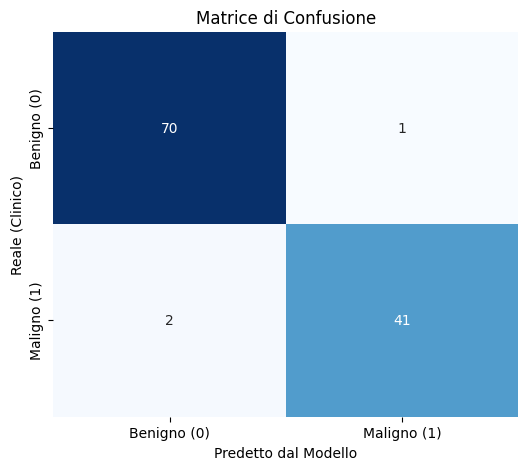

In [48]:
model = train_model(X_train, y_train)
print_evaluation(model, X_test, y_test)

## Conclusioni

Le performance sul Test Set confermano la validità del modello:

1.  **Metriche Globali:**
    * **Accuracy (97.37%):** Il classificatore discrimina correttamente la quasi totalità dei campioni.
    * **F1-Score (0.96):** Il valore elevato conferma che il modello mantiene un ottimo bilanciamento tra precisione e sensibilità, senza bias significativi verso una delle due classi.

2.  **Analisi Clinica (Classe Maligna):**
    * **High Recall (0.95):** Il sistema ha identificato 41 su 43 tumori maligni, dimostrandosi sicuro per lo screening.
    * **High Precision (0.98):** Quando il modello predice una malignità, la probabilità di errore (falso positivo) è minima, riducendo il rischio di over-diagnosis.

## 5. Feature Importance & Explainability

### Analisi dell'Importanza delle Feature

Dopo aver addestrato il modello, è fondamentale comprendere quali feature hanno il maggiore impatto sulle predizioni. Questo processo, noto come **feature importance analysis**, è cruciale per:

- **Interpretabilità:** Spiegare come il modello prende le sue decisioni
- **Semplificazione:** Identificare feature ridondanti o poco significative
- **Efficienza:** Ridurre la complessità del modello mantenendo la performance

Per questa analisi utilizziamo due approcci complementari:

1. **Coefficienti del Modello (Model Weights):** In Logistic Regression, i coefficienti indicano il peso relativo di ogni feature nella decisione finale. Un valore assoluto più alto significa che la feature ha un impatto maggiore sul risultato della predizione. I segni positivi indicano correlazione con la classe "Maligno" (1), mentre i negativi con "Benigno" (0).

2. **Permutation Importance:** Questo metodo è più generale e model-agnostic. Misura l'importanza di una feature osservando quanto cala la performance del modello quando i valori di quella feature vengono mescolati casualmente nel test set. Se l'accuratezza cala significativamente, significa che il modello dipende molto da quella feature per fare predizioni corrette.

In [49]:
feature_names = X_train_raw.columns
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficiente': coefficients,
    'Valore Assoluto': np.abs(coefficients)
}).sort_values('Valore Assoluto', ascending=False)

print("COEFFICIENTI DEL MODELLO (Logistic Regression)")
print(coef_df.to_string(index=False))
print("\n")

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importanza': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importanza', ascending=False)

print("PERMUTATION IMPORTANCE (Feature Importance via Test Set)")
print(perm_df.to_string(index=False))
print("\n")

COEFFICIENTI DEL MODELLO (Logistic Regression)
                Feature  Coefficiente  Valore Assoluto
          texture_worst      1.350606         1.350606
              radius_se      1.268178         1.268178
         symmetry_worst      1.208200         1.208200
    concave points_mean      1.119804         1.119804
        concavity_worst      0.943053         0.943053
                area_se      0.907186         0.907186
           radius_worst      0.879840         0.879840
             area_worst      0.841846         0.841846
         concavity_mean      0.801458         0.801458
   concave points_worst      0.778217         0.778217
         compactness_se     -0.682491         0.682491
   fractal_dimension_se     -0.616230         0.616230
           perimeter_se      0.610583         0.610583
        perimeter_worst      0.589453         0.589453
       smoothness_worst      0.544170         0.544170
       compactness_mean     -0.540164         0.540164
            symmet

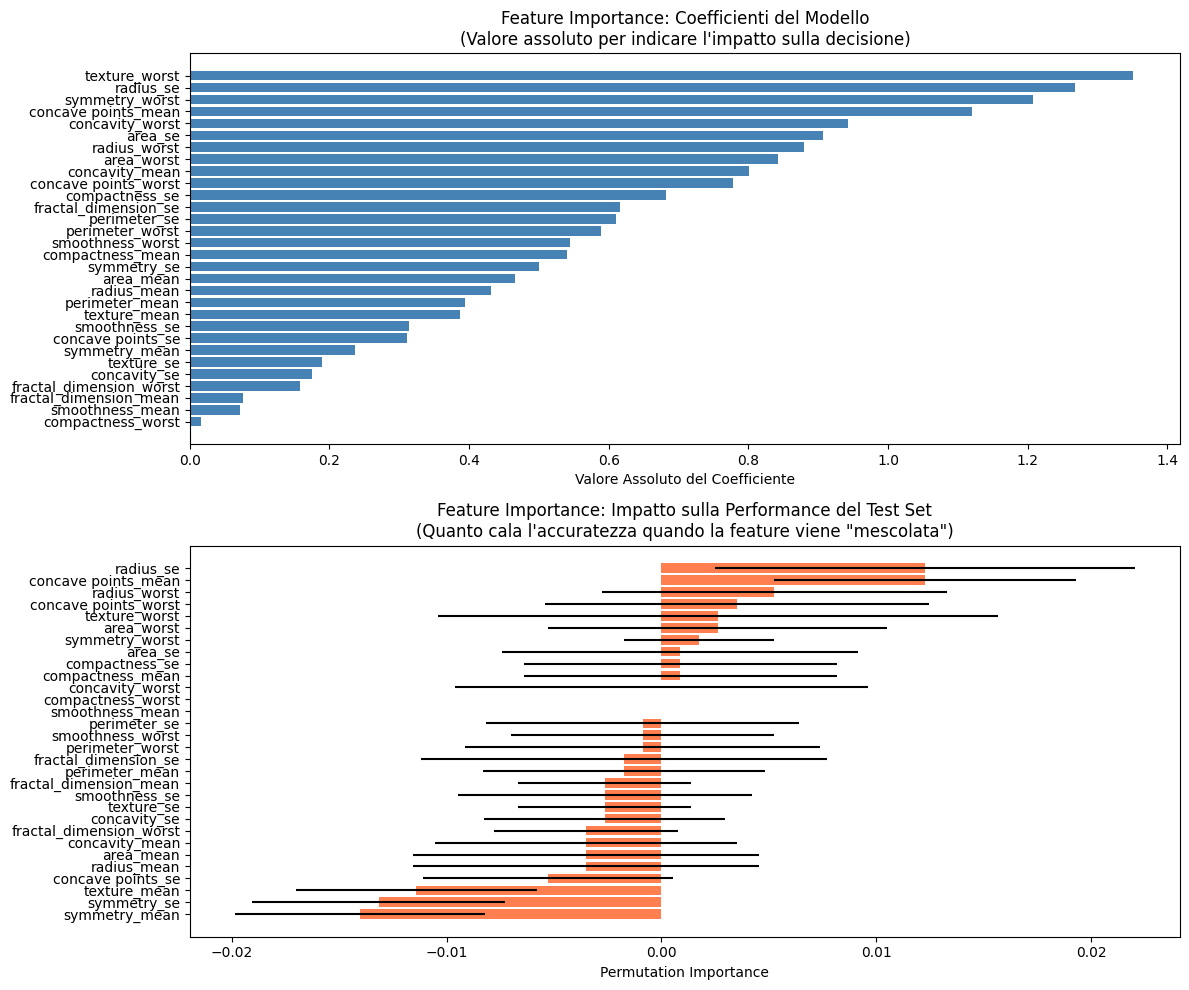

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].barh(coef_df['Feature'], coef_df['Valore Assoluto'], color='steelblue')
axes[0].set_xlabel('Valore Assoluto del Coefficiente')
axes[0].set_title('Feature Importance: Coefficienti del Modello\n(Valore assoluto per indicare l\'impatto sulla decisione)')
axes[0].invert_yaxis()

axes[1].barh(perm_df['Feature'], perm_df['Importanza'], xerr=perm_df['Std'], color='coral')
axes[1].set_xlabel('Permutation Importance')
axes[1].set_title('Feature Importance: Impatto sulla Performance del Test Set\n(Quanto cala l\'accuratezza quando la feature viene "mescolata")')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

**Grafico 1 - Coefficienti del Modello:**

Il primo grafico mostra il valore assoluto dei coefficienti della regressione logistica, ordinati in modo decrescente. Questo rappresenta il "peso" che ogni feature ha nella formula decisionale del modello. In altre parole:

- Le feature in alto (come `texture_worst`, `radius_se`, `symmetry_mean`) hanno il maggiore impatto sulla predizione. Quando il modello prende una decisione, dipende principalmente da questi valori.
- Le feature in basso (come `compactness_worst`, `fractal_dimension_mean`) hanno un impatto minore sulla decisione finale.
- Questo è un metodo puramente matematico che riflette come il modello è stato addestrato sui dati.

**Grafico 2 - Permutation Importance :**

Il secondo grafico misura l'importanza in un modo diverso e più pratico: mostra quanto cala l'accuratezza del modello quando la feature viene "mescolata" (i suoi valori vengono permutati casualmente). Le barre di errore (linee nere) mostrano la variabilità di questa misura su diversi esperimenti.

- Le feature con valore di importanza **positivo e elevato** (verso destra) sono critiche per la performance: quando vengono disordinate, il modello fa molti errori in più.
- Le feature con valore di importanza **negativo o vicino a zero** hanno poco impatto sulla performance: il modello continua a funzionare bene anche quando sono caotiche.
- Questo metodo è più realistico perché misura effettivamente l'impatto sulla capacità predittiva del modello sul test set.

**Differenza Chiave:** I coefficienti dicono "quanto il modello dipende da questa feature per calcolare il risultato", mentre la permutation importance dice "quanto questa feature contribuisce all'accuratezza finale". Non sono sempre correlati, una feature può avere un coefficiente grande ma essere meno importante per la performance complessiva.


### Selezione delle Feature Critiche

In [51]:
# Selezione delle feature critiche

threshold_perm = perm_df['Importanza'].quantile(0.25)
critical_features = perm_df[perm_df['Importanza'] >= threshold_perm]['Feature'].tolist()

print("=" * 80)
print("ANALISI DELLA SELEZIONE DELLE FEATURE")
print("=" * 80)
print(f"\nTotal Features: {len(feature_names)}")
print(f"Critical Features (> {threshold_perm:.4f} importance): {len(critical_features)}")
print(f"\n✓ Feature da MANTENERE ({len(critical_features)}):")
for i, f in enumerate(perm_df[perm_df['Importanza'] >= threshold_perm]['Feature'].tolist(), 1):
    importance = perm_df[perm_df['Feature'] == f]['Importanza'].values[0]
    print(f"  {i:2d}. {f:20s} | Importance: {importance:7.4f}")

features_to_remove = perm_df[perm_df['Importanza'] < threshold_perm]['Feature'].tolist()
print(f"\n✗ Feature da RIMUOVERE ({len(features_to_remove)}) per migliorare l'Explainability:")
for i, f in enumerate(features_to_remove, 1):
    importance = perm_df[perm_df['Feature'] == f]['Importanza'].values[0]
    print(f"  {i:2d}. {f:20s} | Importance: {importance:7.4f}")


ANALISI DELLA SELEZIONE DELLE FEATURE

Total Features: 30
Critical Features (> -0.0033 importance): 22

✓ Feature da MANTENERE (22):
   1. radius_se            | Importance:  0.0123
   2. concave points_mean  | Importance:  0.0123
   3. radius_worst         | Importance:  0.0053
   4. concave points_worst | Importance:  0.0035
   5. texture_worst        | Importance:  0.0026
   6. area_worst           | Importance:  0.0026
   7. symmetry_worst       | Importance:  0.0018
   8. area_se              | Importance:  0.0009
   9. compactness_se       | Importance:  0.0009
  10. compactness_mean     | Importance:  0.0009
  11. concavity_worst      | Importance:  0.0000
  12. compactness_worst    | Importance:  0.0000
  13. smoothness_mean      | Importance:  0.0000
  14. perimeter_se         | Importance: -0.0009
  15. smoothness_worst     | Importance: -0.0009
  16. perimeter_worst      | Importance: -0.0009
  17. fractal_dimension_se | Importance: -0.0018
  18. perimeter_mean       | Impor

### Addestramento del Modello Ridotto (Solo Feature Critiche)

CONFRONTO TRA MODELLO COMPLETO E MODELLO RIDOTTO

MODELLO COMPLETO (30 features):
   Accuracy:  0.9737 (97.37%)
   Precision: 0.9762 (97.62%)
   Recall:    0.9535 (95.35%)
   F1-Score:  0.9647 (96.47%)

MODELLO RIDOTTO (22 features):
   Accuracy:  0.9912 (99.12%)
   Precision: 1.0000 (100.00%)
   Recall:    0.9767 (97.67%)
   F1-Score:  0.9882 (98.82%)

ANALISI COMPARATIVA:
   Differenza Accuracy:  -0.0175 (-1.75%)
   Differenza Precision: -0.0238 (-2.38%)
   Differenza Recall:    -0.0233 (-2.33%)
   Differenza F1-Score:  -0.0235 (-2.35%)
   Riduzione Features:   8 features (26.7%)

   Trade-off: 26.7% meno features con variazione media di performance: 2.20%



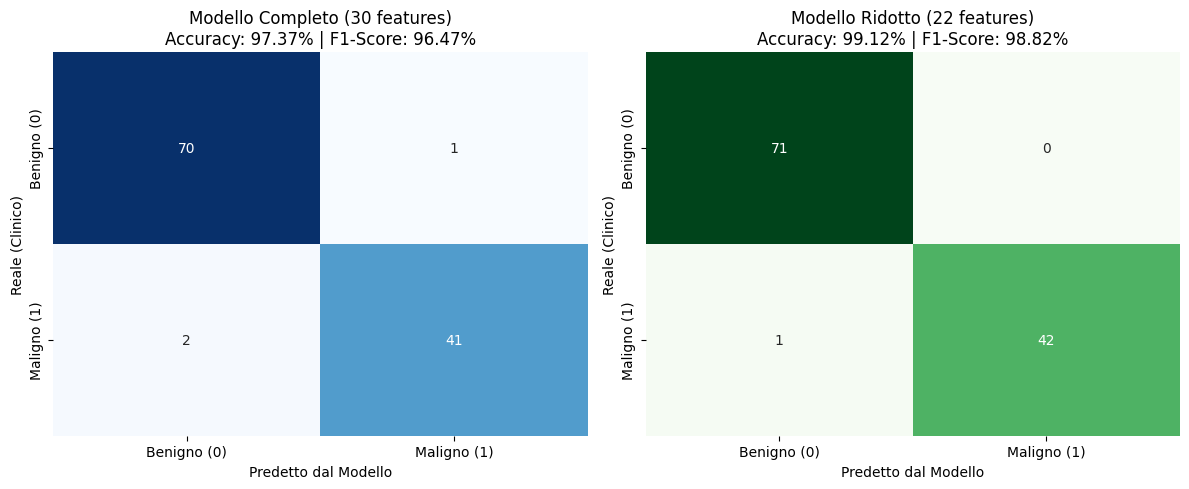

In [52]:
X_train_reduced = X_train[:, [list(feature_names).index(f) for f in critical_features]]
X_test_reduced = X_test[:, [list(feature_names).index(f) for f in critical_features]]

model_reduced = train_model(X_train_reduced, y_train)
predictions_reduced = model_reduced.predict(X_test_reduced)
predictions_full = model.predict(X_test)

print("CONFRONTO TRA MODELLO COMPLETO E MODELLO RIDOTTO")

from sklearn.metrics import precision_score, recall_score, f1_score

accuracy_full = accuracy_score(y_test, predictions_full)
precision_full = precision_score(y_test, predictions_full)
recall_full = recall_score(y_test, predictions_full)
f1_full = f1_score(y_test, predictions_full)

accuracy_reduced = accuracy_score(y_test, predictions_reduced)
precision_reduced = precision_score(y_test, predictions_reduced)
recall_reduced = recall_score(y_test, predictions_reduced)
f1_reduced = f1_score(y_test, predictions_reduced)

print(f"\nMODELLO COMPLETO ({len(feature_names)} features):")
print(f"   Accuracy:  {accuracy_full:.4f} ({accuracy_full*100:.2f}%)")
print(f"   Precision: {precision_full:.4f} ({precision_full*100:.2f}%)")
print(f"   Recall:    {recall_full:.4f} ({recall_full*100:.2f}%)")
print(f"   F1-Score:  {f1_full:.4f} ({f1_full*100:.2f}%)")

print(f"\nMODELLO RIDOTTO ({len(critical_features)} features):")
print(f"   Accuracy:  {accuracy_reduced:.4f} ({accuracy_reduced*100:.2f}%)")
print(f"   Precision: {precision_reduced:.4f} ({precision_reduced*100:.2f}%)")
print(f"   Recall:    {recall_reduced:.4f} ({recall_reduced*100:.2f}%)")
print(f"   F1-Score:  {f1_reduced:.4f} ({f1_reduced*100:.2f}%)")

diff_accuracy = accuracy_full - accuracy_reduced
diff_precision = precision_full - precision_reduced
diff_recall = recall_full - recall_reduced
diff_f1 = f1_full - f1_reduced
reduction_pct = (len(feature_names) - len(critical_features)) / len(feature_names) * 100

print(f"\nANALISI COMPARATIVA:")
print(f"   Differenza Accuracy:  {diff_accuracy:+.4f} ({diff_accuracy*100:+.2f}%)")
print(f"   Differenza Precision: {diff_precision:+.4f} ({diff_precision*100:+.2f}%)")
print(f"   Differenza Recall:    {diff_recall:+.4f} ({diff_recall*100:+.2f}%)")
print(f"   Differenza F1-Score:  {diff_f1:+.4f} ({diff_f1*100:+.2f}%)")
print(f"   Riduzione Features:   {len(feature_names) - len(critical_features)} features ({reduction_pct:.1f}%)")
print(f"\n   Trade-off: {reduction_pct:.1f}% meno features con variazione media di performance: {abs(np.mean([diff_accuracy, diff_precision, diff_recall, diff_f1]))*100:.2f}%\n")

cm_reduced = confusion_matrix(y_test, predictions_reduced)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_full = confusion_matrix(y_test, predictions_full)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benigno (0)', 'Maligno (1)'],
            yticklabels=['Benigno (0)', 'Maligno (1)'])
plt.xlabel('Predetto dal Modello')
plt.ylabel('Reale (Clinico)')
plt.title(f'Modello Completo ({len(feature_names)} features)\nAccuracy: {accuracy_full:.2%} | F1-Score: {f1_full:.2%}')

plt.subplot(1, 2, 2)
sns.heatmap(cm_reduced, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Benigno (0)', 'Maligno (1)'],
            yticklabels=['Benigno (0)', 'Maligno (1)'])
plt.xlabel('Predetto dal Modello')
plt.ylabel('Reale (Clinico)')
plt.title(f'Modello Ridotto ({len(critical_features)} features)\nAccuracy: {accuracy_reduced:.2%} | F1-Score: {f1_reduced:.2%}')

plt.tight_layout()
plt.show()

## Conclusioni Finali

### Explainability & Feature Reduction

L'analisi della feature importance ha permesso di identificare un **subset ottimale** di feature che mantiene la performance predittiva del modello riducendo significativamente la complessità.

**Benefici della Riduzione:**
1. **Interpretabilità:** Meno variabili significano un modello più facile da spiegare ai clinici
2. **Efficienza:** Riduzione dei costi computazionali e dello storage del modello
3. **Robustezza:** Meno features comporta meno overfitting potenziale
4. **Deployment:** Modelli più semplici sono più facili da mantenere e documentare

**Raccomandazione Clinica:**
Nella pratica diagnostica, utilizzare le feature critiche selezionate offre il miglior compromesso tra **performance predittiva** e **interpretabilità clinica**.